In [1]:
import numpy as np


In [2]:
d_model = 768
n_layers = 12

residual_stream = np.random.randn(n_layers, d_model)

residual_stream.shape

(12, 768)

Let's use Einops to rearrange this into a nice array to visualize.

In [3]:
from einops import rearrange, reduce, repeat

residual_stream = rearrange(residual_stream, "layer (row col) -> layer row col", row=16)

residual_stream.shape

(12, 16, 48)

Now we do the simplest plot of such a tensor.

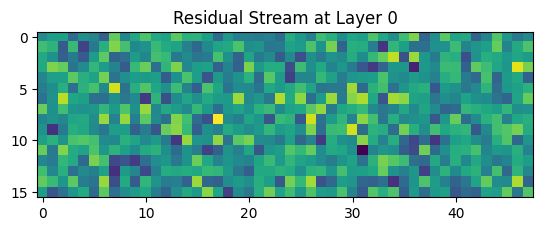

In [4]:
import matplotlib.pyplot as plt

plt.imshow(residual_stream[0], cmap='viridis')
plt.title("Residual Stream at Layer 0")
plt.show()

We want to make this much prettier for the blog.

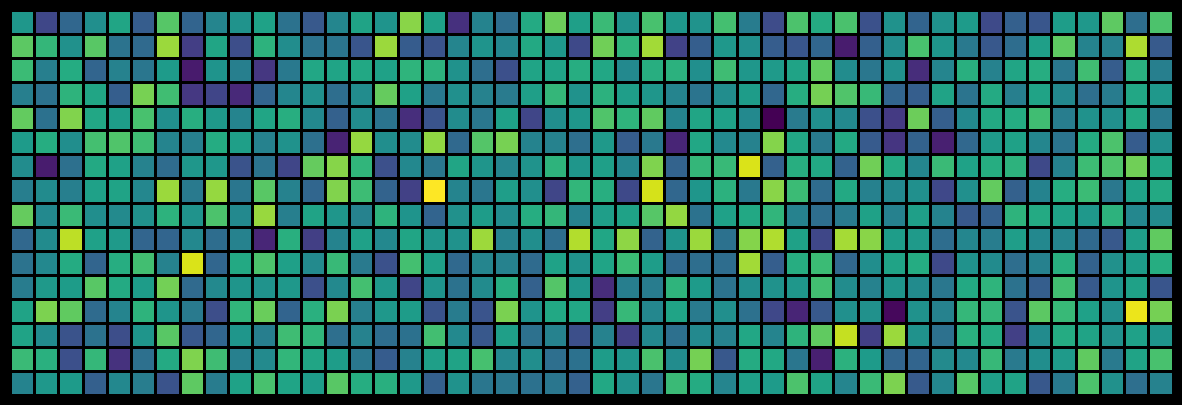

In [5]:
#| label: fig:residual_stream_animation
#| fig-cap: Animation of the Residual Stream Across Layers

fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.axis(False)
fig.set_facecolor('black')
ax.set_facecolor('black')

cmesh = ax.pcolormesh(residual_stream[0], edgecolors='k', cmap='viridis', vmin=-3, vmax=3)

Now we can think about animating this.

In [6]:
from matplotlib.animation import FuncAnimation

def anim_function(frame_num):
    cmesh.set_array(residual_stream[frame_num,:,:])
    return cmesh,

anim = FuncAnimation(fig, anim_function, frames=np.arange(residual_stream.shape[0]), interval=30)

from IPython.display import HTML
HTML(anim.to_jshtml())

Now lets look to do something with actual model activations!

In [7]:
from huggingface_hub import login
login()

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [9]:
inputs = tokenizer(
    "Paris is the capital of",
    padding=True,
    truncation=True,
    return_tensors="pt"
)

print(f"Tokenized {inputs['input_ids'].shape[0]} sequences with max length {inputs['input_ids'].shape[1]}.")

Tokenized 1 sequences with max length 5.


In [10]:
with torch.no_grad():
    outputs = model(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        output_hidden_states=True,
    )

In [11]:
type(outputs.hidden_states)

tuple

In [12]:
outputs.hidden_states[12][0, -1, :]

tensor([ 3.9707e-01,  6.5592e-01, -1.0789e-01, -5.1339e-01,  2.2478e-01,
        -3.5340e-01,  2.9402e+00,  5.0266e-01, -1.1648e-01, -3.3925e-01,
        -1.4641e-01,  1.3185e-01,  5.6856e-01, -2.4193e-01,  2.3383e-01,
        -6.1204e-01, -1.6270e-01,  2.6729e-01,  1.0813e-01, -3.3550e+00,
         3.8122e-01,  3.1480e-01,  3.6961e-01, -1.1843e-01, -4.1384e-02,
         2.7716e-01, -6.5405e-01, -6.8845e-01,  1.7058e-01,  2.3255e-01,
         2.1136e-02, -2.7776e-01,  1.7016e-01,  3.5261e-01,  6.2866e-01,
        -2.2970e-01,  5.0996e+01, -3.4832e-01, -4.9283e-01,  1.6009e-01,
        -2.5912e-01, -4.3954e-02, -6.6652e-02,  1.7371e-02, -4.9989e-02,
         7.7331e-02, -2.0900e-01, -5.2491e-01, -9.1295e-01, -7.5307e-02,
        -5.9557e-02, -3.5249e-01,  9.1986e-02, -4.4967e-02,  1.7474e-01,
         1.0622e+00, -3.1931e-02, -2.3144e-01,  1.4521e-01, -4.0620e-01,
        -5.8457e-01,  1.4042e-02,  1.0694e-01, -1.2151e-01, -1.1069e+00,
         4.4808e-01, -1.6879e-01,  4.8419e-02, -1.2

Now we animate through the residual stream.

In [13]:
residual_stream = np.zeros((13, d_model))

for layer in range(13):
    residual_stream_layer = outputs.hidden_states[layer][0, -1, :].numpy()
    residual_stream[layer] = residual_stream_layer
    print(f"Layer {layer}: Residual stream shape {residual_stream_layer.shape}")

Layer 0: Residual stream shape (768,)
Layer 1: Residual stream shape (768,)
Layer 2: Residual stream shape (768,)
Layer 3: Residual stream shape (768,)
Layer 4: Residual stream shape (768,)
Layer 5: Residual stream shape (768,)
Layer 6: Residual stream shape (768,)
Layer 7: Residual stream shape (768,)
Layer 8: Residual stream shape (768,)
Layer 9: Residual stream shape (768,)
Layer 10: Residual stream shape (768,)
Layer 11: Residual stream shape (768,)
Layer 12: Residual stream shape (768,)


In [14]:
residual_stream = rearrange(residual_stream, "layer (row col) -> layer row col", row=16)

residual_stream.shape

(13, 16, 48)

In [15]:
from ipywidgets import interact, interactive, IntSlider, VBox, HBox, Output
import matplotlib.pyplot as plt

output = Output()

def plot_layer(layer=0):
    with output:
        output.clear_output(wait=True)
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))
        ax.axis(False)
        fig.set_facecolor('black')
        ax.set_facecolor('black')

        cmesh = ax.pcolormesh(residual_stream[layer], edgecolors='black', cmap='viridis', vmin=-3, vmax=3)
        ax.set_title(f'Layer {layer}', color='white', fontsize=16)
        plt.show()

slider = IntSlider(min=0, max=residual_stream.shape[0]-1, step=1, value=0, description='Layer:')
slider.observe(lambda change: plot_layer(change['new']), names='value')

# Initial plot
plot_layer(0)

# Display with slider below and centered
from ipywidgets import Layout
display(VBox([output, HBox([slider], layout=Layout(justify_content='center'))],
             layout=Layout(background_color='white')))